In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from cdlib import algorithms, evaluation
from sklearn.metrics import normalized_mutual_info_score as NMI
import os
from cdlib import algorithms, evaluation
from matplotlib.colors import ListedColormap

cmap=ListedColormap(['r','g','b','c','m','darkred','k','grey','pink','orange','mediumpurple','olive'])

# Helper Functions

In [7]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=6.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.circular_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.circular_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos


# Load Data

In [4]:
g = nx.read_gml('football.gml')
yDict = {i:g._node[i]['value'] for i in g.nodes()}
y = [yDict[i] for i in g.nodes()]

# Unstructured graph

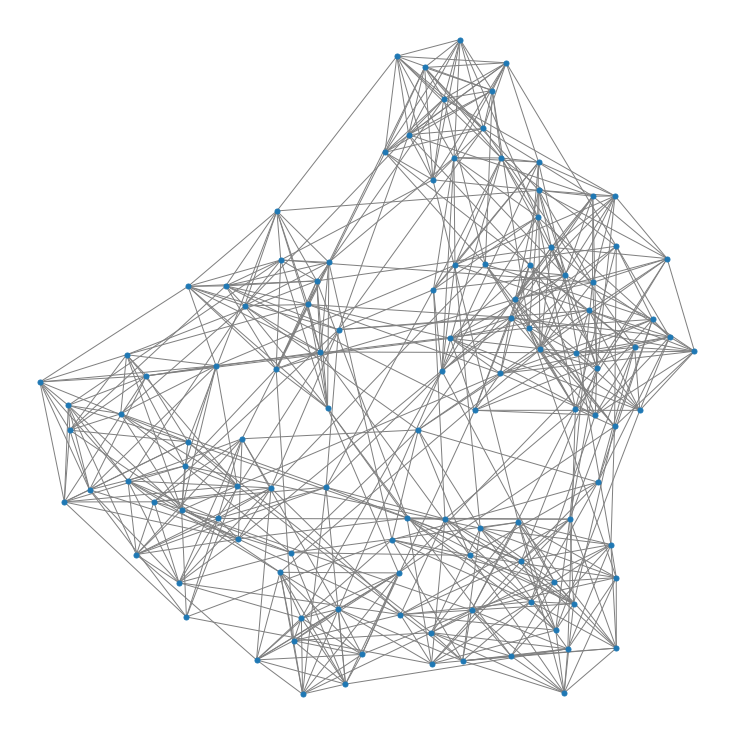

In [5]:
plt.figure(figsize=(10,10))
nx.draw(g, node_size=25, edge_color='gray')
plt.show()

# Structured graph

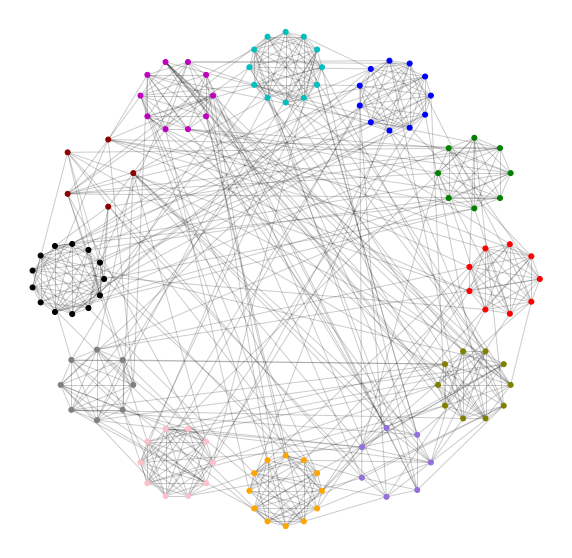

In [8]:
pos = community_layout(g,yDict)
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(g, pos, cmap=cmap, node_color=y, node_size=25)
nx.draw_networkx_edges(g, pos, alpha=0.2)
plt.axis('off')
plt.show()

# Spectral Modularity Maximization

Community size: 2, Modularity score: 0.3757, NMI: 0.3264
Community size: 3, Modularity score: 0.3891, NMI: 0.3933
Community size: 4, Modularity score: 0.4083, NMI: 0.4653
Community size: 4, Modularity score: 0.4083, NMI: 0.4653
Community size: 5, Modularity score: 0.4123, NMI: 0.5021
Community size: 5, Modularity score: 0.4123, NMI: 0.5021
Community size: 5, Modularity score: 0.4123, NMI: 0.5021
Community size: 5, Modularity score: 0.4123, NMI: 0.5021
Community size: 6, Modularity score: 0.4824, NMI: 0.6192
Community size: 7, Modularity score: 0.4905, NMI: 0.6583
Community size: 7, Modularity score: 0.4905, NMI: 0.6583
Community size: 8, Modularity score: 0.4926, NMI: 0.6987
Community size: 8, Modularity score: 0.4926, NMI: 0.6987


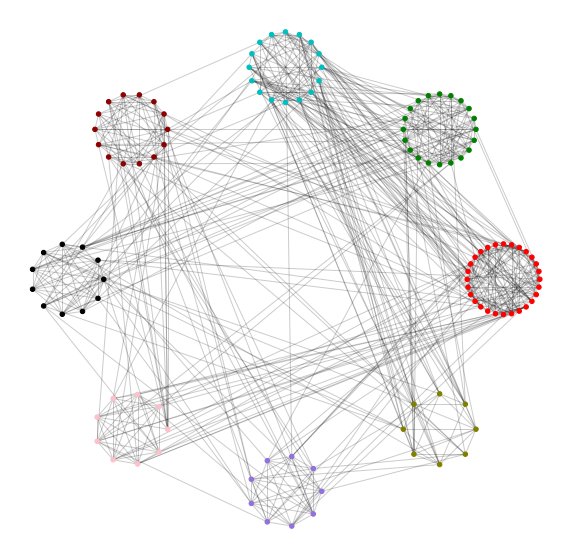

In [9]:
for i in range(2,15):
    c = algorithms.eigenvector(g,i)
    mod = evaluation.newman_girvan_modularity(g,c)
    cs = len(c.communities)
    pred = {}
    for i in range(len(c.communities)):
        for j in c.communities[i]:
            pred.update({j:i})
    
    yhat = [pred[i] for i in g.nodes()]
    
    nmi=NMI(y,yhat)
    print('Community size: {}, Modularity score: {:.4f}, NMI: {:.4f}'.format(cs,mod[2],
                                                                 nmi))

pos = community_layout(g,pred)
plt.figure(figsize=(10,10))
#nx.draw_networkx(g,node_color='red',node_size=20, with_labels =False)
nx.draw_networkx_nodes(g, pos, cmap=cmap, node_color=yhat, node_size=20)
nx.draw_networkx_edges(g, pos, alpha=0.2)
plt.axis('off')
plt.show()

# Louvain

Community size: 10, Modularity score: 0.6046, NMI: 0.8903
Community size: 11, Modularity score: 0.6032, NMI: 0.9095
Community size: 13, Modularity score: 0.5811, NMI: 0.9111


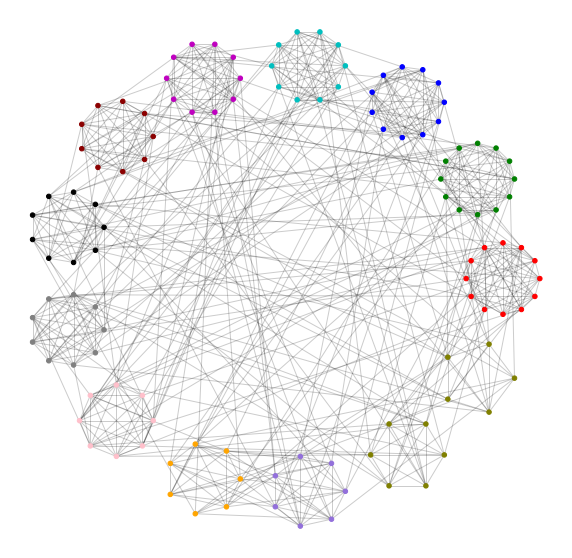

In [12]:
for i in range(1,4):
    c = algorithms.louvain(g,resolution=i,randomize=True)
    mod = evaluation.newman_girvan_modularity(g,c)
    cs = len(c.communities)
    pred = {}
    for i in range(len(c.communities)):
        for j in c.communities[i]:
            pred.update({j:i})
    
    yhat = [pred[i] for i in g.nodes()]
    
    nmi=NMI(y,yhat)
    print('Community size: {}, Modularity score: {:.4f}, NMI: {:.4f}'.format(cs,mod[2],
                                                                     nmi))


pos = community_layout(g,pred)
plt.figure(figsize=(10,10))
#nx.draw_networkx(g,node_color='red',node_size=20, with_labels =False)
nx.draw_networkx_nodes(g, pos, cmap=cmap, node_color=yhat, node_size=20)
nx.draw_networkx_edges(g, pos, alpha=0.2)
plt.axis('off')
plt.show()


# LPA

Community size: 11, Modularity score: 0.5831, NMI: 0.8697


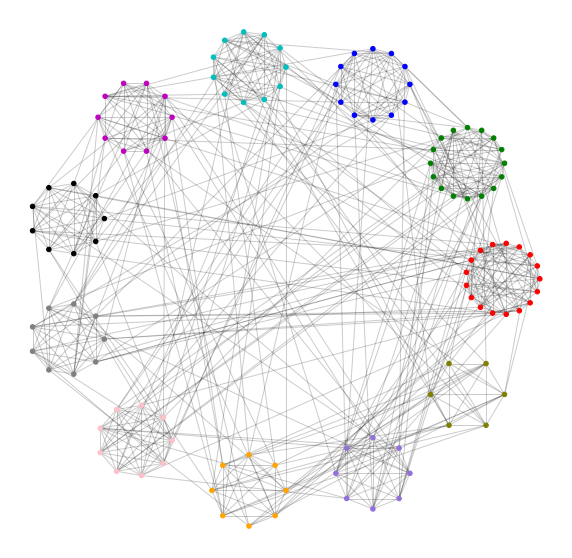

In [13]:
c = algorithms.label_propagation(g)
mod = evaluation.newman_girvan_modularity(g,c)
cs = len(c.communities)
pred = {}
for i in range(len(c.communities)):
    for j in c.communities[i]:
        pred.update({j:i})

yhat = [pred[i] for i in g.nodes()]

nmi=NMI(y,yhat)
print('Community size: {}, Modularity score: {:.4f}, NMI: {:.4f}'.format(cs,mod[2],
                                                                 nmi))
    


pos = community_layout(g,pred)
plt.figure(figsize=(10,10))
#nx.draw_networkx(g,node_color='red',node_size=20, with_labels =False)
nx.draw_networkx_nodes(g, pos, cmap= cmap, node_color=yhat, node_size=20)
nx.draw_networkx_edges(g, pos, alpha=0.2)
plt.axis('off')
plt.show()